In [1]:
import sys
import os
import pandas as pd

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, \
    scale, \
    metrics_r, get_device, plot_history, load_best_params, print_best_params_nn, fmt_time, save_best_params, \
    save_tuning_history, plot_tuning_heatmap, print_tuning_top_results, load_tuning_history,plot_param_loss_corr

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train, tune

## Settings

In [5]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

## Data

### Read Features and Targets

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


### Train-Validation Split

In [9]:
X, y = train_val_split(X, y)

### Scale Regression Targets

In [10]:
y, y_scaler = scale(y)

In [11]:
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}

### Dimensions

In [12]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


### Torch Datasets and Dataloaders

In [13]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Define Parameter Grid

In [15]:
criterion = nn.MSELoss()
metrics = metrics_r
log_metrics = ["mae"]

param_grid = {
    # Architecture Params
    # "hidden_size": [128, 256, 512, 1024],
    "hidden_size": [64, 128, 256, 512],
    "activation": ["relu", "gelu"],
    # "dropout": [0, 0.1, 0.3, 0.5],
    "dropout": [0.05, 0.1, 0.2],
    # "blocks": [1, 2, 3, 5, 10],
    "blocks": [1, 2, 3],
    "hidden_size_pattern": ["decreasing", "constant"],

    # Training Params
    # "lr": [1e-2, 1e-3, 1e-4, 1e-5],
    "lr": [1e-2, 5e-3, 1e-3, 5e-4],
    # "weight_decay": [1e-5, 1e-6, 1e-7],
}

## Load or Initialize Best Params & Tuning History

In [14]:
# Load or initialize best params dictionary and tuning history table
path_params = "best_params.json"
path_history = "tuning_history.csv"

best_params = load_best_params(path_params)
print(f"Best Params Available for {len(best_params.keys())} Models")

tuning_histories = load_tuning_history(path_history)

Best Params Available for 5 Models


## Run Model Tuning



In [16]:
flag_new_model = False

def tune_helper(fts):
    global flag_new_model, best_params, tuning_histories
    ft = " + ".join(fts)

    if ft not in best_params.keys():
        flag_new_model = True
        print(f"\n🔄 Tuning MLP with '{ft.upper()}' Features")
        tuning_result, tuning_history = tune(
            param_grid,
            [X_dim[_ft] for _ft in fts],
            y_dim,
            loaders["train"][ft],
            loaders["val"][ft],
            criterion,
            metrics,
            device,
            y_scaler,
            log_metrics=log_metrics,
            log_per_M=100,
            chronology_target="years"
        )

        best_params[ft] = tuning_result
        tuning_histories[ft] = tuning_history
    else:
        print(f"\n✅ MLP with '{ft.upper()}' Features Already Tuned.", end=" ")
        print_best_params_nn(best_params[ft], param_grid, y_dim, log_metrics)

for ft in feature_types:
    tune_helper([ft])

for ft_txt, ft_img in feature_type_combos:
    tune_helper([ft_txt, ft_img])


✅ MLP with 'TFIDF' Features Already Tuned. Execution Time: 4m 59s
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr |  val_loss |     mae_0 |     mae_1 |
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+
|      BEST |         256 |       relu |    0.05 |      2 |            constant |   0.01 |    0.6325 |   36.6791 |    9.7317 |
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+

✅ MLP with 'BERT' Features Already Tuned. Execution Time: 8m 53s
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr |  val_loss |   

## Save Best Params & Tuning History

In [17]:
save_best_params("best_params.json", best_params, flag_new_model)
save_tuning_history("tuning_history.csv", tuning_histories, flag_new_model)

✅ Saved best parameters to best_params.json
✅ Saved tuning history to tuning_history.csv


## Evaluate Tuning Results

(0.6324566602706909, 1.087588667869568)


📈 Tuning results for BERT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1037,gelu,2,0.20,128,constant,0.005,0.705590,0.788530,44.350258,10.441607,57.560631,13.184586,0.336819,0.136525,34.936600,9.519643
790,relu,3,0.05,256,constant,0.001,0.642048,0.794776,44.374954,10.899263,57.686596,13.235193,0.333913,0.129883,34.589020,10.586864
737,relu,2,0.20,64,decreasing,0.005,0.666163,0.795354,43.719227,11.136584,56.734825,13.399606,0.355711,0.108131,34.364014,11.242774
781,relu,3,0.05,128,constant,0.005,0.630156,0.798928,43.699512,10.953934,56.915283,13.461399,0.351606,0.099887,32.806885,10.787626
809,relu,3,0.10,128,decreasing,0.005,0.702669,0.799186,44.012131,11.113572,56.178421,13.563412,0.368287,0.086193,36.659561,10.123899



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
884,gelu,1,0.05,256,constant,0.0100,0.512901,0.804164,43.197510,11.213600,55.859650,13.654819,0.375435,0.073834,33.255798,10.472540
602,relu,1,0.05,512,decreasing,0.0010,0.518420,0.823984,43.348747,11.310513,56.447315,13.819439,0.362225,0.051368,35.754242,10.581861
1057,gelu,3,0.05,64,decreasing,0.0050,0.536754,0.817581,43.364288,11.096178,57.431446,13.620005,0.339792,0.078551,34.465271,10.214997
1139,gelu,3,0.20,256,decreasing,0.0005,0.594313,0.830425,43.415665,11.483914,56.075581,13.969556,0.370597,0.030647,33.342560,10.883236
1137,gelu,3,0.20,256,decreasing,0.0050,0.598241,0.823955,43.446400,11.212315,58.271400,13.595034,0.320340,0.081927,33.814865,10.596781



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1037,gelu,2,0.2,128,constant,0.0050,0.705590,0.788530,44.350258,10.441607,57.560631,13.184586,0.336819,0.136525,34.936600,9.519643
1145,gelu,3,0.2,512,decreasing,0.0050,0.786112,0.858561,50.757824,10.782590,63.056801,13.077014,0.204125,0.150558,46.541428,10.057874
854,relu,3,0.2,256,constant,0.0010,0.713749,0.809718,47.661129,10.784245,59.114857,13.109882,0.300522,0.146282,41.553192,9.743850
661,relu,1,0.2,256,constant,0.0050,0.648643,0.799998,45.949890,10.806410,57.748772,13.234446,0.332477,0.129982,36.763474,9.789705
619,relu,1,0.1,128,decreasing,0.0005,0.684942,0.840947,48.439941,10.814091,60.376175,13.364814,0.270354,0.112757,41.121124,9.292017


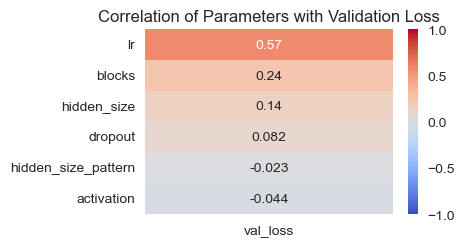

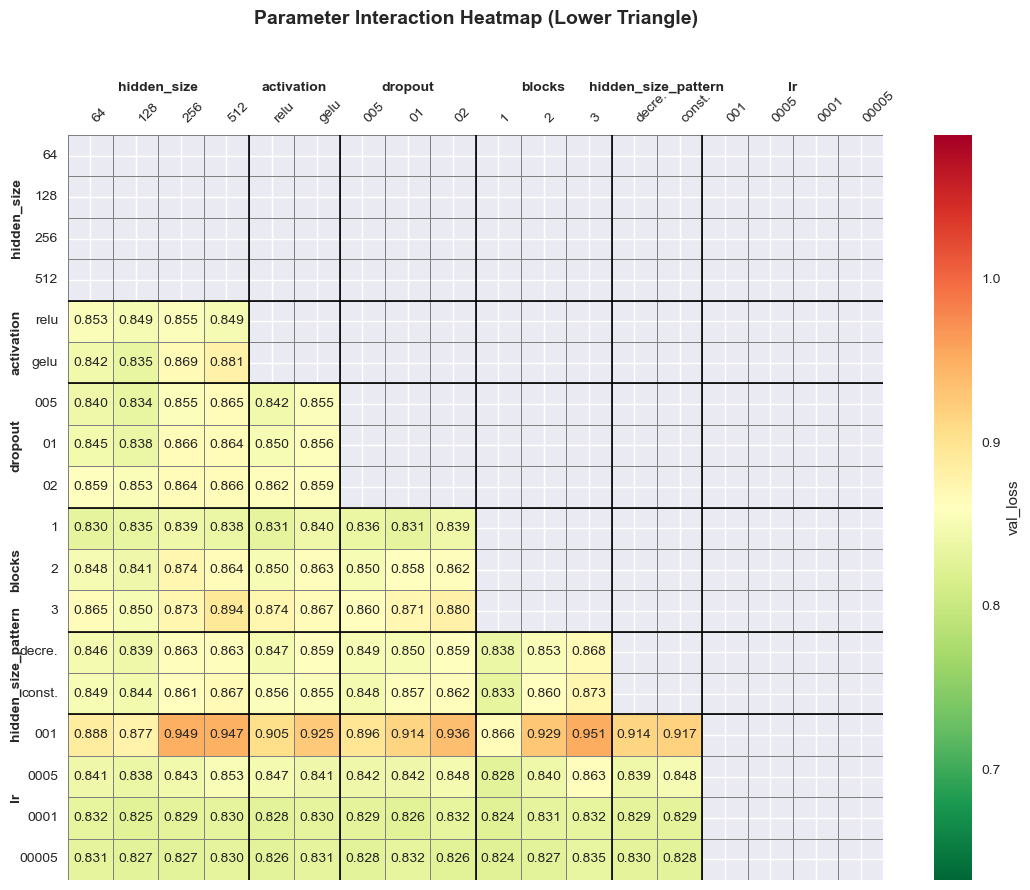



📈 Tuning results for CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1389,relu,3,0.10,128,constant,0.005,0.878110,0.975009,53.519112,12.300952,65.024490,14.361521,0.153679,-0.024513,46.179779,9.406498
1385,relu,3,0.10,128,decreasing,0.005,0.871872,0.983516,54.239120,12.310601,65.581337,14.352881,0.139122,-0.023281,50.042221,9.800386
1365,relu,3,0.05,256,constant,0.005,0.872593,0.986577,52.505665,12.293683,64.992905,14.414004,0.154501,-0.032015,46.466064,9.010342
1186,relu,1,0.10,64,decreasing,0.001,0.846314,0.987738,53.871300,12.336860,65.462639,14.434395,0.142235,-0.034937,51.147690,10.524198
1153,relu,1,0.05,64,decreasing,0.005,0.858105,0.989998,54.147472,12.297761,65.599388,14.380977,0.138648,-0.027291,55.700623,10.299460



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1365,relu,3,0.05,256,constant,0.0050,0.872593,0.986577,52.505665,12.293683,64.992905,14.414004,0.154501,-0.032015,46.466064,9.010342
1667,gelu,3,0.10,64,decreasing,0.0005,0.834780,0.996215,53.321594,12.400995,65.793190,14.468790,0.133551,-0.039875,46.938141,11.215925
1658,gelu,3,0.05,512,decreasing,0.0010,0.823840,1.000870,53.426563,12.189174,66.463127,14.313787,0.115816,-0.017715,44.771301,10.159705
1654,gelu,3,0.05,256,constant,0.0010,0.811205,1.000817,53.440659,12.311097,66.075203,14.442704,0.126107,-0.036129,44.322540,10.073364
1686,gelu,3,0.10,256,constant,0.0010,0.824407,1.000340,53.469818,12.175833,66.617233,14.365315,0.111711,-0.025055,46.113892,9.784992



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1656,gelu,3,0.05,512,decreasing,0.010,191.405426,1.064001,59.322792,11.680367,70.771599,14.252707,-0.002534,-0.009047,47.997772,7.970816
1504,gelu,1,0.20,64,decreasing,0.010,2.808553,1.070919,59.329823,11.851034,71.047997,14.297164,-0.010380,-0.015352,52.628601,8.502644
1596,gelu,2,0.10,512,constant,0.010,1.024071,1.067613,60.062084,11.852122,71.015739,14.324282,-0.009463,-0.019207,49.382812,9.537986
1724,gelu,3,0.20,512,constant,0.010,1.041717,1.058736,59.320175,11.873636,70.654953,14.258309,0.000768,-0.009841,43.732971,9.081384
1661,gelu,3,0.05,512,constant,0.005,1.004435,1.068434,59.524738,11.884246,71.439293,14.192079,-0.021540,-0.000481,54.720001,7.982843


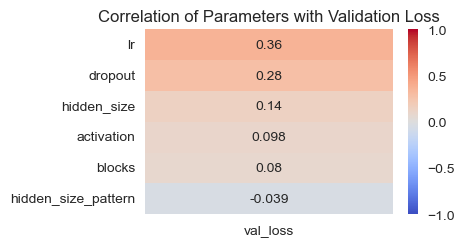

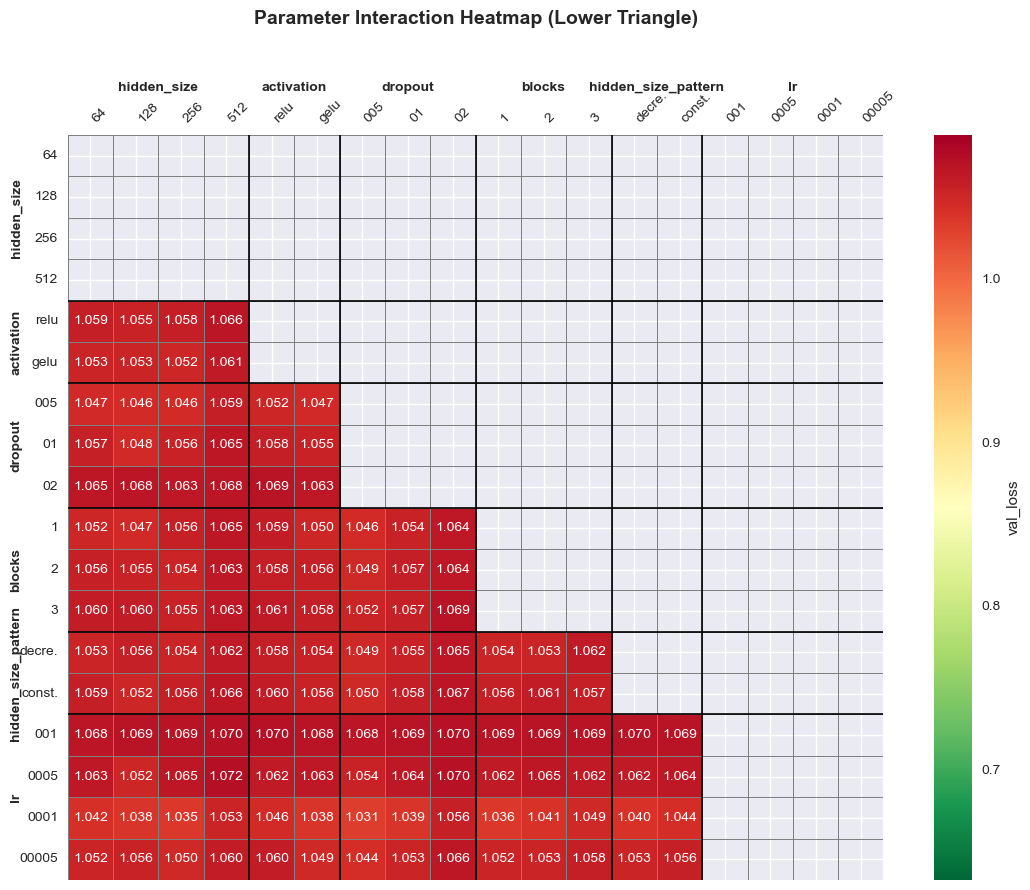



📈 Tuning results for RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1923,relu,3,0.05,64,decreasing,0.0005,0.840493,0.908585,48.713730,12.084531,61.048912,14.217548,0.254003,-0.004075,44.017975,10.367788
1987,relu,3,0.20,64,decreasing,0.0005,0.832605,0.912531,49.974758,11.925225,61.882713,14.086976,0.233487,0.014283,45.373566,10.058638
2111,gelu,1,0.20,512,constant,0.0005,0.821320,0.912614,50.962719,11.700133,62.326118,14.028887,0.222463,0.022395,43.700012,8.936334
1935,relu,3,0.05,128,constant,0.0005,0.807976,0.916345,49.998791,11.730498,62.402889,14.032668,0.220546,0.021868,43.568512,8.546911
1850,relu,2,0.05,512,decreasing,0.0010,0.842089,0.917810,49.786083,11.755581,62.342236,14.116347,0.222061,0.010168,43.049942,8.958382



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2236,gelu,3,0.05,512,constant,0.010,0.760788,0.921410,47.804874,12.048666,61.256477,14.339015,0.248922,-0.021305,37.530060,10.338655
2301,gelu,3,0.20,512,constant,0.005,0.688121,0.962456,48.051826,12.179010,63.679409,14.404408,0.188331,-0.030642,35.802155,10.455556
1880,relu,2,0.10,512,decreasing,0.010,0.697225,0.925980,48.056412,12.206323,61.361191,14.375251,0.246352,-0.026473,40.864975,10.061642
1805,relu,1,0.20,128,constant,0.005,0.702200,0.932309,48.115723,12.336440,61.183922,14.512520,0.250700,-0.046170,41.848846,10.261208
2096,gelu,1,0.20,256,decreasing,0.010,0.716667,0.945511,48.142372,12.327125,62.109146,14.523953,0.227867,-0.047820,37.876801,10.641666



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2047,gelu,1,0.05,512,constant,0.0005,0.893819,0.944248,51.841007,11.376763,63.496536,14.169228,0.192986,0.002738,44.668549,8.402039
1890,relu,2,0.20,64,decreasing,0.0010,0.789807,0.942414,51.069630,11.436316,63.949097,14.076735,0.181441,0.015715,44.177185,8.227411
2108,gelu,1,0.20,512,constant,0.0100,0.949245,0.942074,52.554550,11.438345,64.034683,14.092914,0.179249,0.013452,45.118118,9.185299
2066,gelu,1,0.10,256,decreasing,0.0010,0.808659,0.944772,51.126625,11.455121,62.651272,14.314991,0.214329,-0.017886,43.561737,8.787943
1820,relu,1,0.20,512,constant,0.0100,0.845234,0.938591,52.505558,11.464186,64.129143,14.019642,0.176825,0.023683,45.670731,8.768391


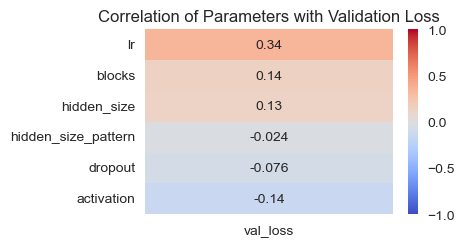

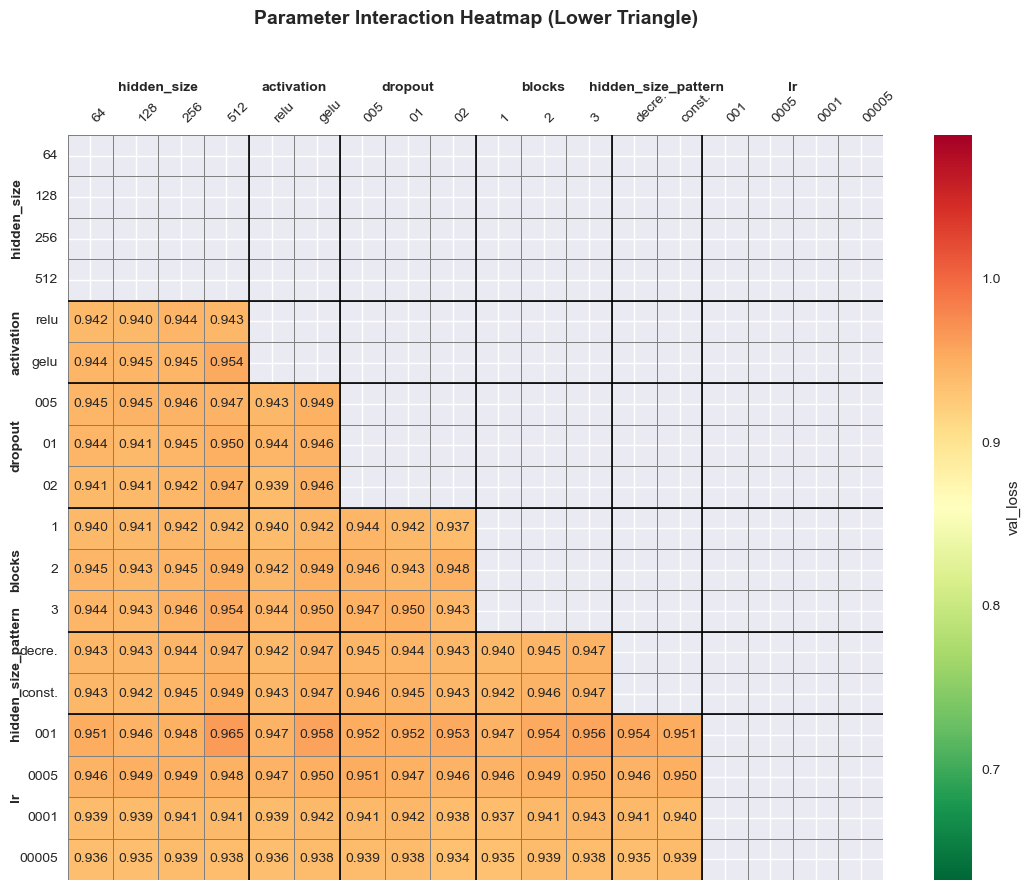



📈 Tuning results for TFIDF features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
116,relu,2,0.05,256,constant,0.010,0.450685,0.632457,36.679062,9.731664,48.592926,12.000129,0.527364,0.284699,25.144150,8.136385
44,relu,1,0.10,128,constant,0.010,0.272852,0.653132,35.328289,9.996985,48.748638,12.289658,0.524330,0.249767,27.465118,8.828225
264,relu,3,0.20,128,decreasing,0.010,0.420651,0.657569,33.961323,10.428954,46.260426,12.792789,0.571648,0.187081,24.877411,9.568367
253,relu,3,0.10,512,constant,0.005,0.280657,0.662447,34.625092,10.277556,45.666264,12.915123,0.582581,0.171459,27.540466,9.218784
113,relu,2,0.05,256,decreasing,0.005,0.131197,0.663272,34.325668,9.945801,46.663700,12.791255,0.564148,0.187276,22.132858,7.034634



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
124,relu,2,0.05,512,constant,0.010,0.096613,0.678718,33.443615,9.960835,46.087204,13.174225,0.574850,0.137882,25.375488,7.353726
152,relu,2,0.10,512,decreasing,0.010,0.058063,0.686310,33.524776,10.133410,45.229687,13.319001,0.590524,0.118829,24.023727,7.144865
264,relu,3,0.20,128,decreasing,0.010,0.420651,0.657569,33.961323,10.428954,46.260426,12.792789,0.571648,0.187081,24.877411,9.568367
113,relu,2,0.05,256,decreasing,0.005,0.131197,0.663272,34.325668,9.945801,46.663700,12.791255,0.564148,0.187276,22.132858,7.034634
169,relu,2,0.20,128,decreasing,0.005,0.343876,0.677172,34.594002,10.610640,46.235287,12.984189,0.572114,0.162574,25.754379,9.247027



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
284,relu,3,0.20,512,constant,0.010,0.184447,0.689773,36.495525,9.722477,49.059761,12.917019,0.518239,0.171216,28.179321,6.201434
116,relu,2,0.05,256,constant,0.010,0.450685,0.632457,36.679062,9.731664,48.592926,12.000129,0.527364,0.284699,25.144150,8.136385
248,relu,3,0.10,512,decreasing,0.010,0.148367,0.676046,34.717812,9.863379,47.239021,12.794481,0.553334,0.186866,24.283691,7.571270
165,relu,2,0.20,64,constant,0.005,0.592275,0.673580,38.765400,9.897432,51.480480,12.174270,0.469523,0.263788,28.933167,9.075359
113,relu,2,0.05,256,decreasing,0.005,0.131197,0.663272,34.325668,9.945801,46.663700,12.791255,0.564148,0.187276,22.132858,7.034634


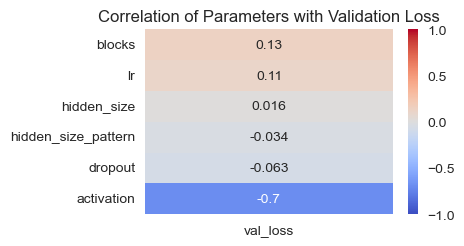

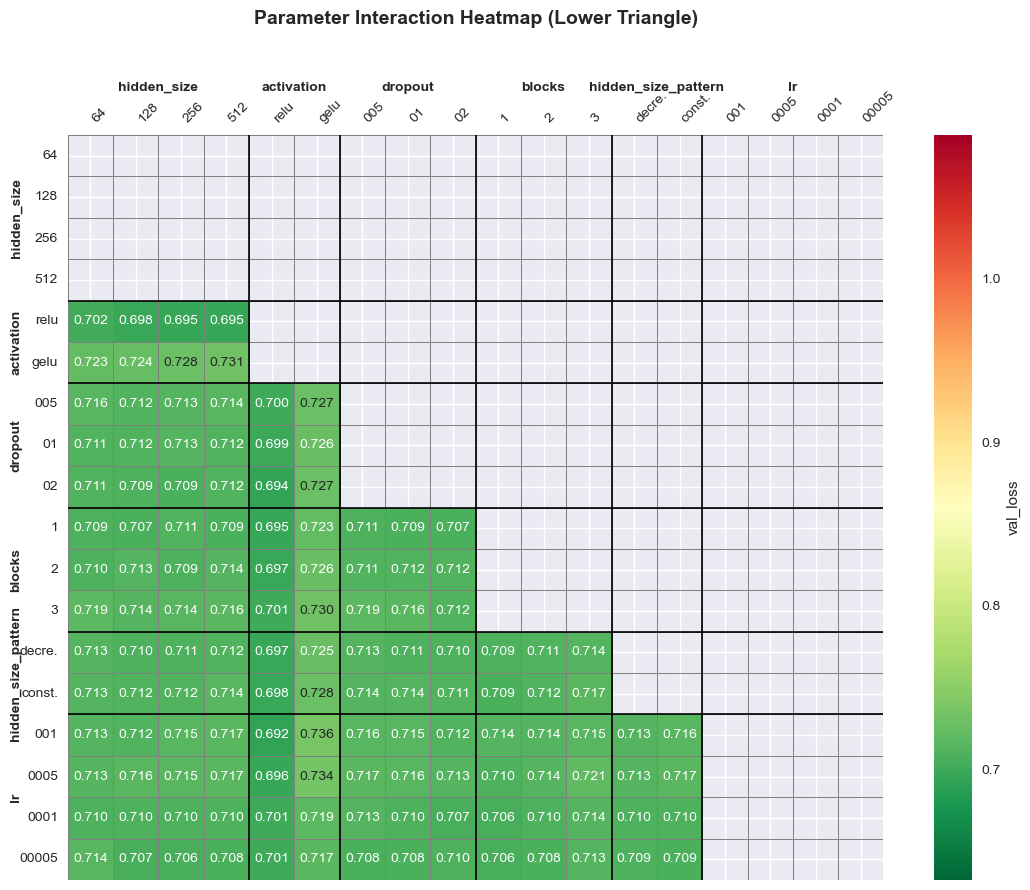



📈 Tuning results for VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2817,gelu,3,0.10,64,decreasing,0.005,0.750242,0.893683,48.166920,11.708277,60.673782,14.046468,0.263143,0.019944,40.028412,8.807526
2384,relu,1,0.20,256,decreasing,0.010,0.703941,0.895483,46.179161,11.807036,59.865395,14.141718,0.282647,0.006607,36.825836,8.963532
2385,relu,1,0.20,256,decreasing,0.005,0.764508,0.897203,48.476654,11.573776,60.976212,13.978812,0.255779,0.029362,42.107773,8.756355
2524,relu,3,0.05,512,constant,0.010,0.803017,0.898782,47.246838,11.730828,60.677719,14.089714,0.263047,0.013899,38.237305,8.915136
2789,gelu,3,0.05,64,constant,0.005,0.766165,0.899828,48.857914,11.268637,61.870037,13.910179,0.233801,0.038870,41.394333,8.136868



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2384,relu,1,0.20,256,decreasing,0.010,0.703941,0.895483,46.179161,11.807036,59.865395,14.141718,0.282647,0.006607,36.825836,8.963532
2369,relu,1,0.20,64,decreasing,0.005,0.720508,0.903984,46.237644,12.014950,59.775627,14.296885,0.284797,-0.015312,34.004242,9.693560
2478,relu,2,0.20,128,constant,0.001,0.684376,0.922838,46.262562,11.935512,60.577076,14.357067,0.265490,-0.023878,36.932709,8.887070
2652,gelu,1,0.10,512,constant,0.010,0.682713,0.927473,46.317535,12.069566,60.541637,14.416458,0.266349,-0.032367,35.737030,9.244856
2414,relu,2,0.05,128,constant,0.001,0.699096,0.914849,46.337852,11.760136,60.867325,14.218349,0.258435,-0.004188,39.650558,8.814816



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2828,gelu,3,0.10,128,constant,0.010,0.914572,0.943068,54.384949,11.229343,65.509377,13.757883,0.141010,0.059800,41.253418,8.049764
2789,gelu,3,0.05,64,constant,0.005,0.766165,0.899828,48.857914,11.268637,61.870037,13.910179,0.233801,0.038870,41.394333,8.136868
2328,relu,1,0.05,512,decreasing,0.010,0.790646,0.930937,51.796761,11.326736,64.730453,13.816572,0.161316,0.051762,42.141815,8.630163
2458,relu,2,0.10,512,decreasing,0.001,0.743509,0.923035,49.138649,11.340468,62.425686,14.045951,0.219976,0.020016,40.742935,8.483570
2824,gelu,3,0.10,128,decreasing,0.010,0.838934,0.907163,50.199268,11.361959,62.272697,13.866553,0.223795,0.044889,44.111221,8.335155


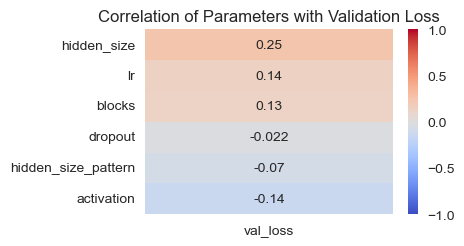

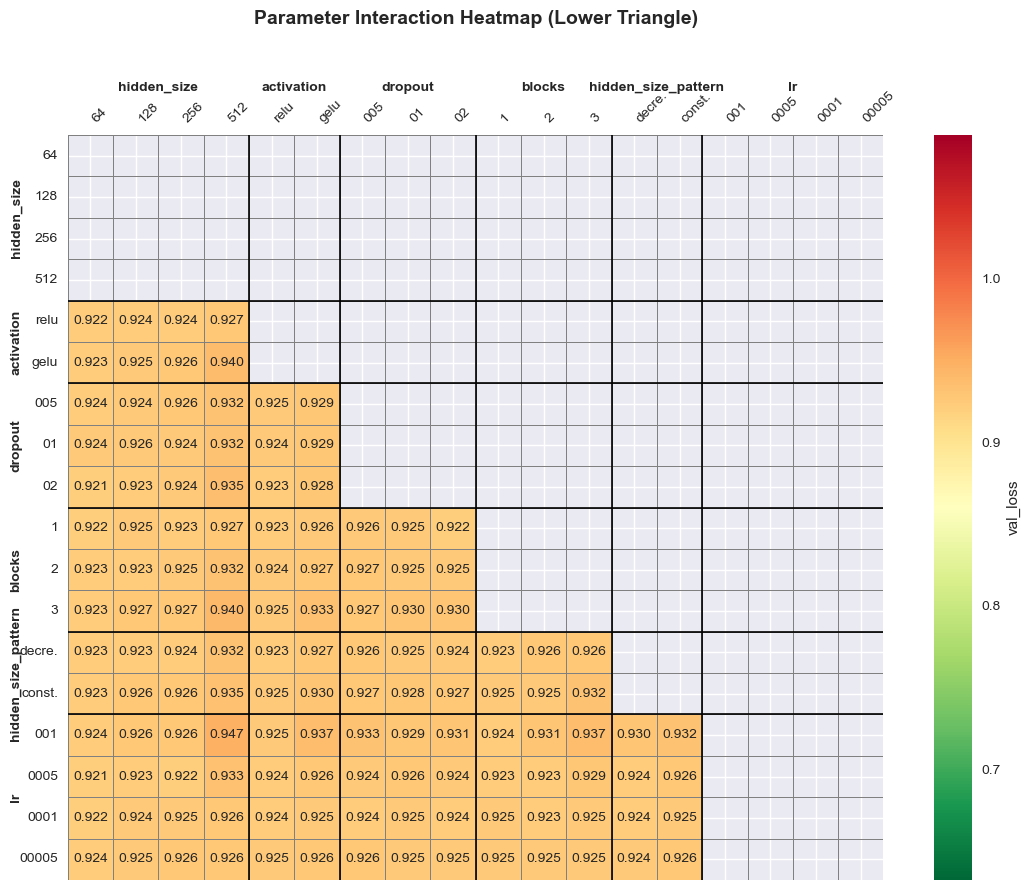



📈 Tuning results for TFIDF + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
156,relu,2,0.1,512,constant,0.010,0.166096,0.653383,34.349815,9.832291,47.137856,12.609012,0.555245,0.210270,26.838943,7.289707
184,relu,2,0.2,512,decreasing,0.010,0.524178,0.661528,36.729980,10.143842,48.980453,12.386480,0.519795,0.237899,27.351669,9.787335
188,relu,2,0.2,512,constant,0.010,0.605213,0.663935,38.075638,10.120515,49.551331,12.422750,0.508536,0.233429,27.682175,8.916941
249,relu,3,0.1,512,decreasing,0.005,0.341543,0.665398,37.060299,10.313720,48.667751,12.574362,0.525907,0.214604,28.625687,9.141459
144,relu,2,0.1,256,decreasing,0.010,0.306177,0.668341,36.393147,9.972755,49.172112,12.440239,0.516030,0.231269,25.854279,8.783207



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
156,relu,2,0.10,512,constant,0.010,0.166096,0.653383,34.349815,9.832291,47.137856,12.609012,0.555245,0.210270,26.838943,7.289707
222,relu,3,0.05,512,constant,0.001,0.078703,0.724814,34.958824,10.684199,48.454624,13.384166,0.530050,0.110186,25.093292,7.673652
84,relu,1,0.20,256,constant,0.010,0.427364,0.697008,35.253010,10.608236,48.094170,13.046398,0.537016,0.154530,27.027023,9.681212
152,relu,2,0.10,512,decreasing,0.010,0.233096,0.721075,35.421604,10.495458,48.902962,13.213409,0.521313,0.132745,26.331833,8.631135
196,relu,3,0.05,64,constant,0.010,0.282628,0.722252,35.441921,10.445545,50.218151,13.127379,0.495220,0.144002,23.350266,8.485857



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
156,relu,2,0.10,512,constant,0.01,0.166096,0.653383,34.349815,9.832291,47.137856,12.609012,0.555245,0.210270,26.838943,7.289707
276,relu,3,0.20,256,constant,0.01,0.514128,0.673883,39.521549,9.920555,50.990887,12.327081,0.479565,0.245191,30.670135,8.429142
212,relu,3,0.05,256,constant,0.01,0.395038,0.695796,38.188313,9.945347,50.345543,12.710057,0.492655,0.197561,27.962479,7.791564
144,relu,2,0.10,256,decreasing,0.01,0.306177,0.668341,36.393147,9.972755,49.172112,12.440239,0.516030,0.231269,25.854279,8.783207
20,relu,1,0.05,256,constant,0.01,0.569674,0.704849,40.296993,10.012809,53.353245,12.365333,0.430226,0.240499,27.543060,9.302889


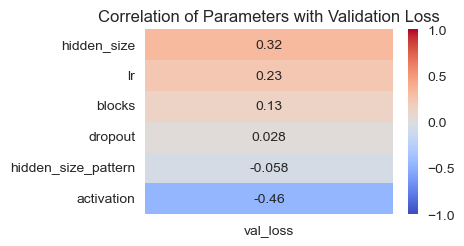

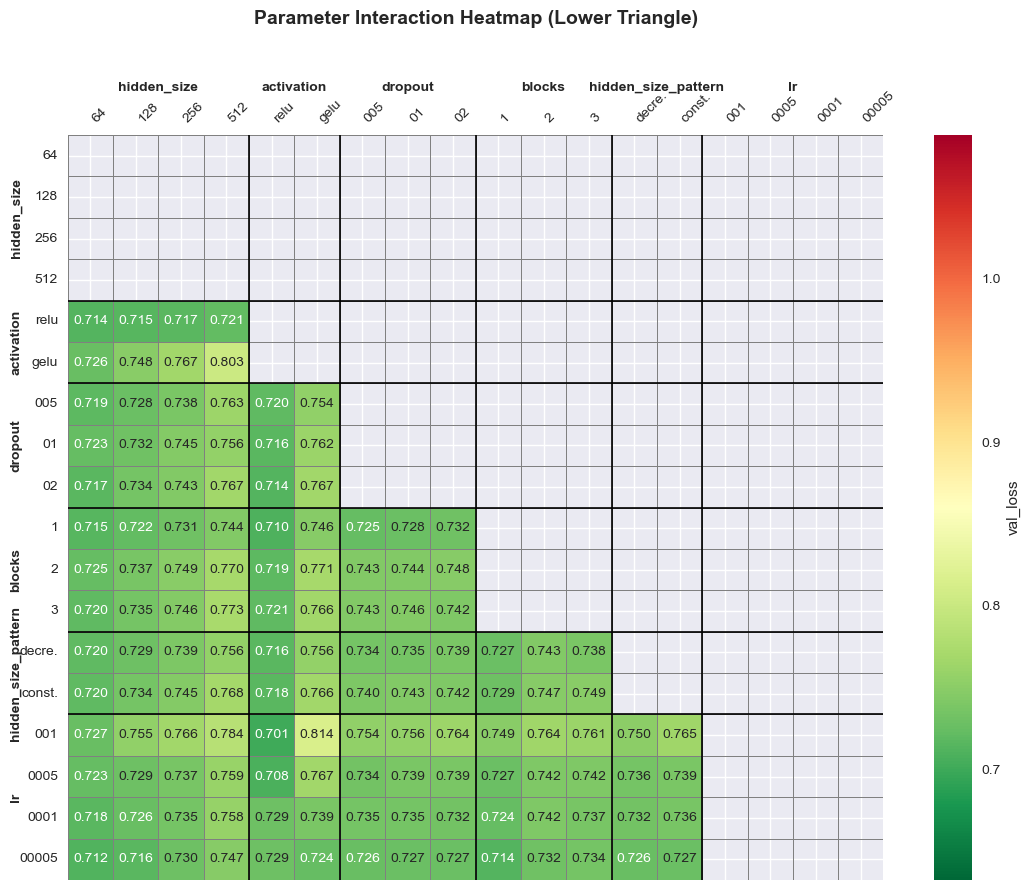



📈 Tuning results for TFIDF + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
127,relu,2,0.05,512,constant,0.0005,0.415506,0.643668,34.594139,10.590027,44.542709,12.876354,0.602868,0.176426,26.503952,9.101030
283,relu,3,0.20,512,decreasing,0.0005,0.381869,0.647382,35.091690,10.522643,45.173714,12.867876,0.591537,0.177510,29.179855,9.166504
145,relu,2,0.10,256,decreasing,0.0050,0.456259,0.649638,35.138077,10.257118,45.415821,12.768466,0.587147,0.190169,28.682327,9.049824
287,relu,3,0.20,512,constant,0.0005,0.400831,0.650184,34.107826,10.490286,43.898117,12.999569,0.614279,0.160589,27.471207,9.145864
88,relu,1,0.20,512,decreasing,0.0100,0.539085,0.651158,36.762302,10.178428,47.454960,12.526930,0.549241,0.220518,27.952087,9.857857



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
125,relu,2,0.05,512,constant,0.005,0.073557,0.681143,32.305794,10.666306,44.194862,13.458031,0.609047,0.100337,23.219574,8.628214
276,relu,3,0.20,256,constant,0.010,0.230117,0.652210,32.857887,9.927859,46.066463,12.685658,0.575233,0.200639,20.867004,7.013958
61,relu,1,0.10,512,constant,0.005,0.024033,0.675351,33.714817,10.205678,46.576488,12.911557,0.565775,0.171917,22.632187,8.066662
274,relu,3,0.20,256,decreasing,0.001,0.370583,0.665779,34.070431,10.609069,44.248352,13.184632,0.608100,0.136519,27.905060,8.386854
49,relu,1,0.10,256,decreasing,0.005,0.084142,0.672914,34.103203,10.391619,46.127476,12.941098,0.574107,0.168123,25.180374,8.189219



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
281,relu,3,0.2,512,decreasing,0.005,0.280595,0.659473,35.848171,9.863530,47.526581,12.713052,0.547879,0.197183,27.550079,7.709924
276,relu,3,0.2,256,constant,0.010,0.230117,0.652210,32.857887,9.927859,46.066463,12.685658,0.575233,0.200639,20.867004,7.013958
81,relu,1,0.2,256,decreasing,0.005,0.054131,0.655634,34.556709,9.954782,46.501720,12.741064,0.567168,0.193641,26.307144,7.545472
188,relu,2,0.2,512,constant,0.010,0.177993,0.669066,34.817150,10.011489,47.502686,12.761612,0.548334,0.191038,23.144730,8.404216
280,relu,3,0.2,512,decreasing,0.010,0.377199,0.667072,36.232361,10.018456,48.652260,12.615727,0.526209,0.209428,26.175751,8.468252


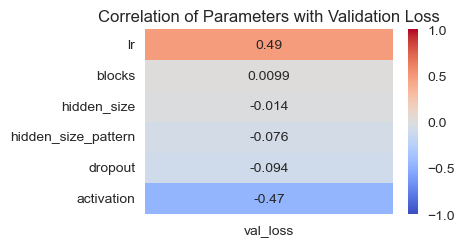

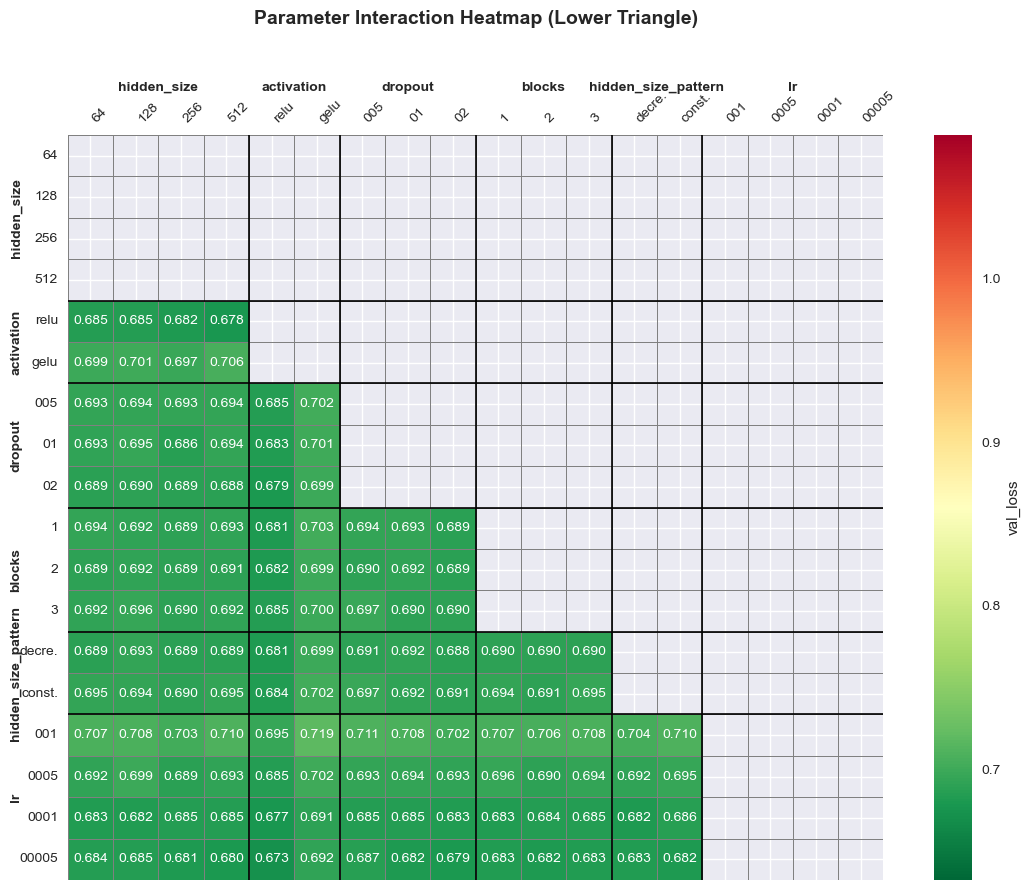



📈 Tuning results for TFIDF + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
89,relu,1,0.20,512,decreasing,0.005,0.427236,0.632634,34.958115,10.205871,45.735783,12.420926,0.581309,0.233654,28.177307,9.496475
17,relu,1,0.05,256,decreasing,0.005,0.407073,0.641809,34.172726,10.336501,45.875164,12.597111,0.578753,0.211760,26.419968,8.905180
222,relu,3,0.05,512,constant,0.001,0.229196,0.644418,33.808609,10.142802,44.757343,12.764775,0.599032,0.190637,28.228363,7.741034
77,relu,1,0.20,128,constant,0.005,0.453078,0.644926,35.015434,10.157895,45.721088,12.599539,0.581578,0.211456,26.945297,8.757442
285,relu,3,0.20,512,constant,0.005,0.342739,0.645334,34.150948,10.357920,44.618229,12.827527,0.601521,0.182660,26.034271,9.366560



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
184,relu,2,0.20,512,decreasing,0.010,0.124108,0.695690,33.409302,10.448559,46.625889,13.300187,0.564854,0.121317,23.146057,7.980438
262,relu,3,0.20,64,constant,0.001,0.430534,0.654155,33.420071,10.450512,44.955708,12.899038,0.595470,0.173522,22.901871,8.978657
240,relu,3,0.10,256,decreasing,0.010,0.182062,0.662525,33.563698,10.277615,45.878281,12.845350,0.578696,0.180387,23.442474,8.166325
284,relu,3,0.20,512,constant,0.010,0.426191,0.662690,33.601223,10.224432,46.084614,12.783349,0.574898,0.188280,22.547928,8.767113
222,relu,3,0.05,512,constant,0.001,0.229196,0.644418,33.808609,10.142802,44.757343,12.764775,0.599032,0.190637,28.228363,7.741034



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
351,gelu,1,0.1,512,constant,0.0005,0.519292,0.692294,40.787163,9.897629,51.281921,12.457911,0.473608,0.229084,33.889679,8.735720
257,relu,3,0.2,64,decreasing,0.0050,0.535354,0.655723,37.161594,9.902576,49.022106,12.310949,0.518978,0.247165,28.115936,8.962021
40,relu,1,0.1,128,decreasing,0.0100,0.202118,0.655289,34.939293,9.976828,47.462666,12.573916,0.549095,0.214660,24.399887,8.608602
86,relu,1,0.2,256,constant,0.0010,0.465856,0.658140,36.652229,9.977027,48.027924,12.515015,0.538291,0.222000,27.541168,8.793299
32,relu,1,0.1,64,decreasing,0.0100,0.558544,0.680002,39.656200,9.985945,50.581833,12.383839,0.487882,0.238224,31.225876,9.261412


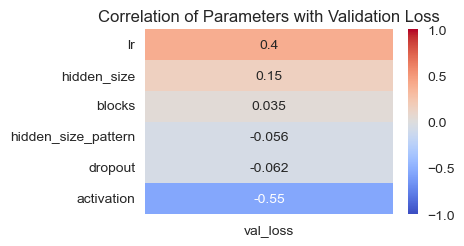

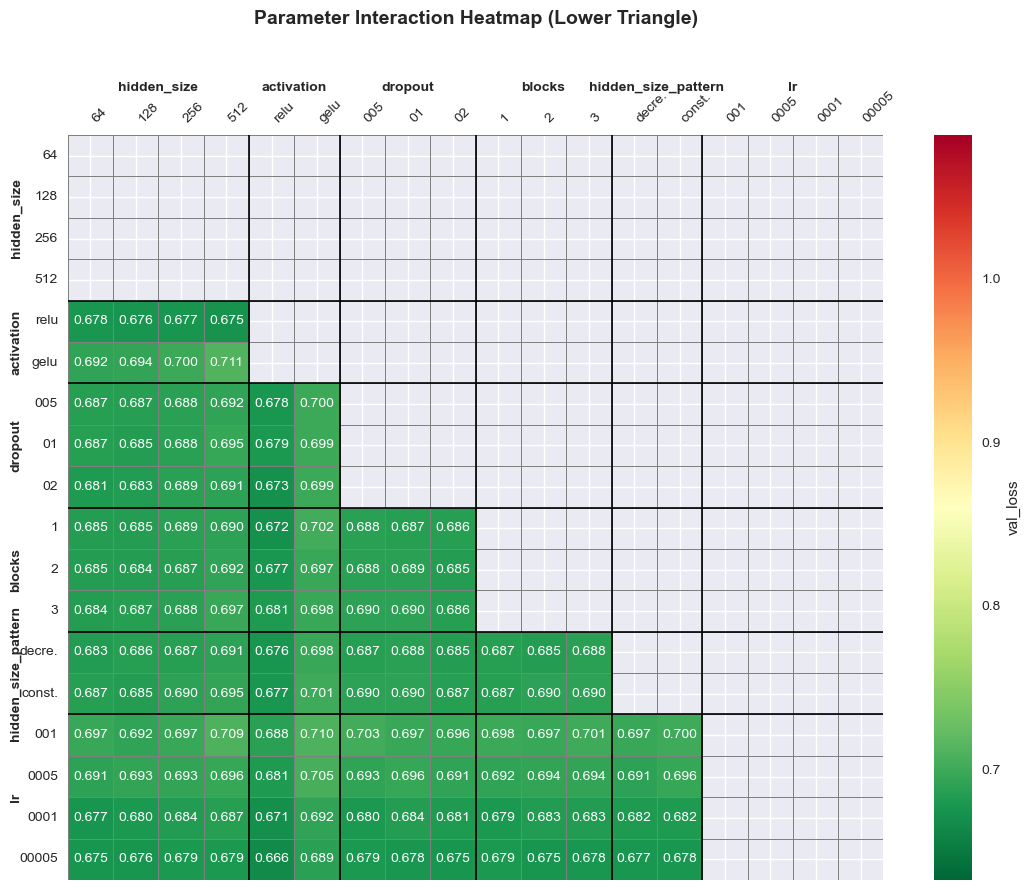



📈 Tuning results for BERT + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
130,relu,2,0.1,64,decreasing,0.0010,0.552269,0.777563,41.138100,11.155351,54.147594,13.528681,0.413133,0.090866,31.176041,10.413787
353,gelu,1,0.2,64,decreasing,0.0050,0.620014,0.780159,41.750553,11.035585,54.798702,13.512793,0.398935,0.093001,31.584442,10.138544
357,gelu,1,0.2,64,constant,0.0050,0.602697,0.782300,43.955742,10.722404,56.256851,13.225142,0.366521,0.131205,36.465515,9.635917
239,relu,3,0.1,128,constant,0.0005,0.534345,0.783409,41.317379,11.060090,54.279171,13.533664,0.410278,0.090196,32.503235,9.911018
79,relu,1,0.2,128,constant,0.0005,0.490740,0.788439,41.452110,11.141291,54.405136,13.658531,0.407538,0.073331,32.881119,10.548710



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
151,relu,2,0.10,256,constant,0.0005,0.445524,0.799020,40.742699,11.310114,53.508110,13.898124,0.426913,0.040535,32.243637,10.527063
215,relu,3,0.05,256,constant,0.0005,0.435896,0.846728,40.971832,11.449617,55.938744,14.215257,0.373665,-0.003752,32.052429,10.089007
130,relu,2,0.10,64,decreasing,0.0010,0.552269,0.777563,41.138100,11.155351,54.147594,13.528681,0.413133,0.090866,31.176041,10.413787
183,relu,2,0.20,256,constant,0.0005,0.509948,0.798782,41.239532,11.201293,54.452579,13.774740,0.406504,0.057495,33.166718,10.217528
522,gelu,3,0.10,128,decreasing,0.0010,0.523607,0.799418,41.253040,11.332334,54.723518,13.735476,0.400583,0.062860,30.836609,10.433817



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
357,gelu,1,0.2,64,constant,0.005,0.602697,0.782300,43.955742,10.722404,56.256851,13.225142,0.366521,0.131205,36.465515,9.635917
574,gelu,3,0.2,512,constant,0.001,0.661383,0.806372,45.714581,10.742155,58.530384,13.168229,0.314285,0.138666,40.007782,9.252384
81,relu,1,0.2,256,decreasing,0.005,0.645766,0.806021,46.506107,10.749239,58.726238,13.222349,0.309688,0.131572,40.012772,9.937835
224,relu,3,0.1,64,decreasing,0.010,0.940064,0.970620,58.160019,10.751829,69.759392,13.256588,0.025938,0.127068,49.629745,10.191083
557,gelu,3,0.2,128,constant,0.005,0.667488,0.831377,47.499104,10.774368,60.943249,13.195769,0.256583,0.135059,36.088135,9.869925


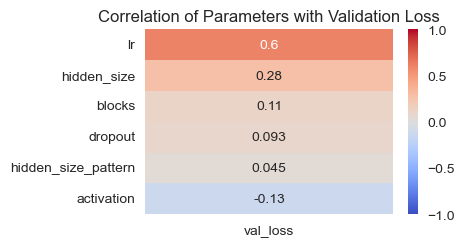

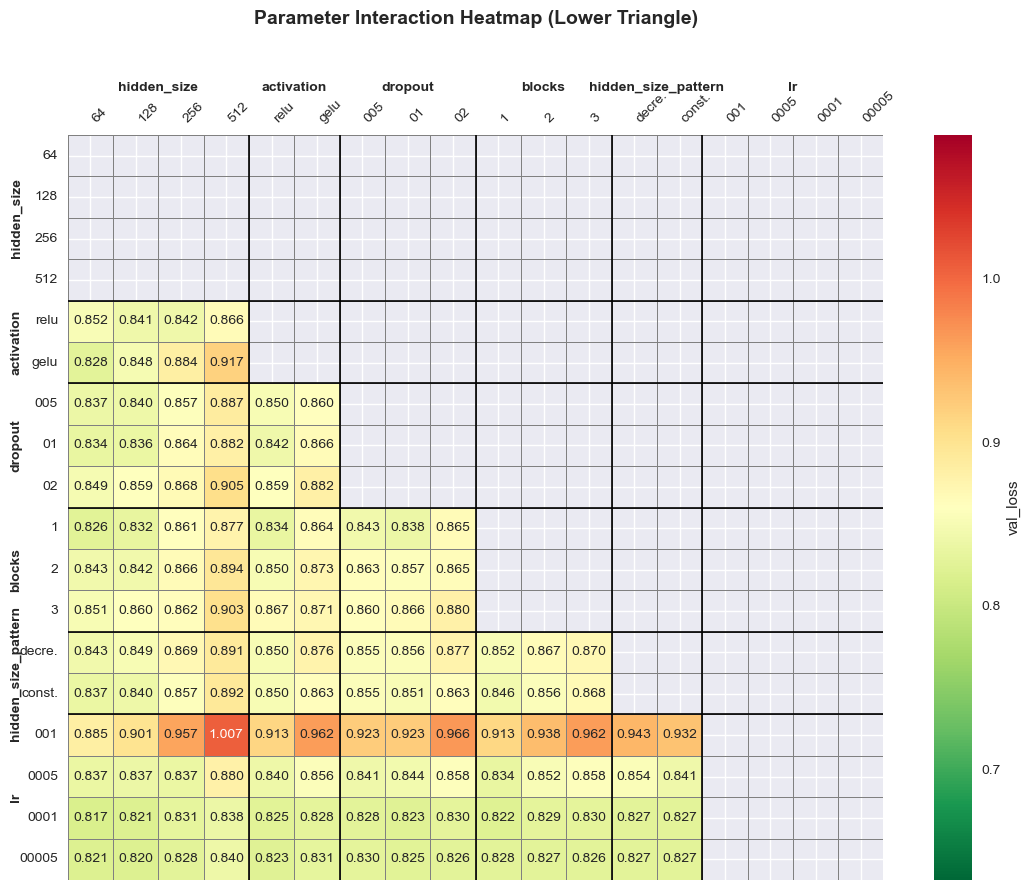



📈 Tuning results for BERT + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
555,gelu,3,0.20,128,decreasing,0.0005,0.545989,0.776004,42.394535,10.815521,54.761009,13.472402,0.399761,0.098415,36.390198,10.009187
187,relu,2,0.20,512,decreasing,0.0005,0.458511,0.781631,40.509281,10.999905,54.246456,13.591966,0.410989,0.082341,31.752258,9.786856
305,gelu,1,0.05,256,decreasing,0.0050,0.380147,0.783023,39.879978,10.982006,53.670063,13.704585,0.423439,0.067071,28.775330,9.609921
82,relu,1,0.20,256,decreasing,0.0010,0.433679,0.784670,40.778870,11.069092,54.303196,13.633561,0.409756,0.076716,32.617645,9.937780
258,relu,3,0.20,64,decreasing,0.0010,0.556965,0.785392,43.018856,11.018748,55.603344,13.456005,0.381154,0.100608,36.298660,10.037267



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
325,gelu,1,0.10,64,constant,0.0050,0.432468,0.803340,39.585686,11.733550,52.475296,14.193774,0.448823,-0.000720,31.321075,11.022316
26,relu,1,0.05,512,decreasing,0.0010,0.378037,0.829646,39.712330,11.428164,54.830822,14.157731,0.398230,0.004356,28.879486,9.948362
42,relu,1,0.10,128,decreasing,0.0010,0.411809,0.797064,39.844051,11.232131,54.468353,13.820944,0.406160,0.051162,29.938568,10.161379
305,gelu,1,0.05,256,decreasing,0.0050,0.380147,0.783023,39.879978,10.982006,53.670063,13.704585,0.423439,0.067071,28.775330,9.609921
215,relu,3,0.05,256,constant,0.0005,0.439779,0.800932,39.932976,11.283386,54.073864,13.898661,0.414731,0.040461,30.729996,9.708547



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
131,relu,2,0.10,64,decreasing,0.0005,0.574095,0.797922,44.795471,10.543528,57.357819,13.320138,0.341484,0.118679,36.877106,9.398764
530,gelu,3,0.10,256,decreasing,0.0010,0.683623,0.809438,45.890903,10.557593,59.072109,13.267019,0.301533,0.125694,37.044495,9.664318
167,relu,2,0.20,64,constant,0.0005,0.610908,0.794763,45.301517,10.604162,57.227116,13.272503,0.344482,0.124971,38.236176,8.654100
239,relu,3,0.10,128,constant,0.0005,0.633334,0.804801,45.394306,10.616154,58.225567,13.314883,0.321408,0.119374,37.623245,8.598591
206,relu,3,0.05,128,constant,0.0010,0.535468,0.786840,44.254635,10.641439,55.680344,13.447765,0.379438,0.101709,40.595993,9.492760


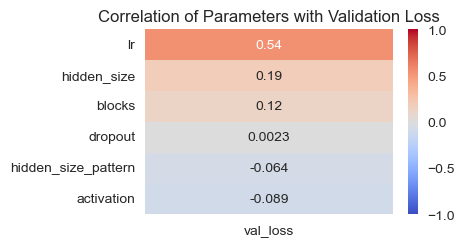

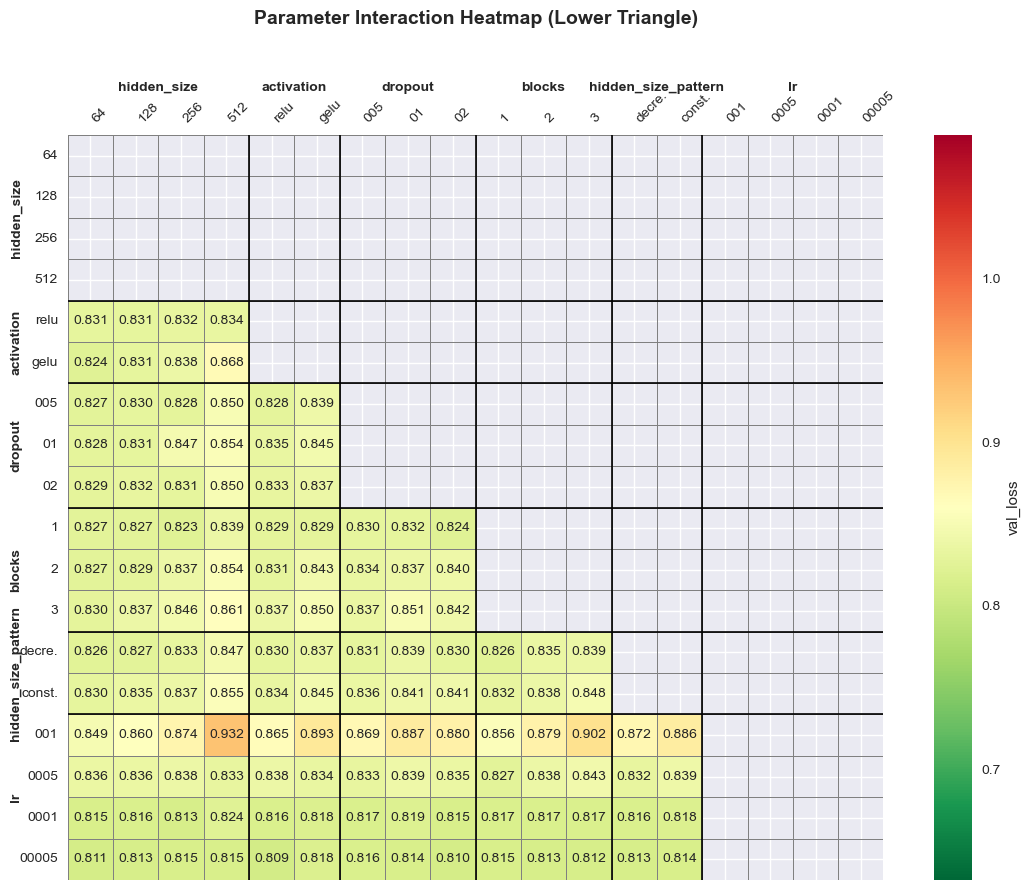



📈 Tuning results for BERT + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
119,relu,2,0.05,256,constant,0.0005,0.538582,0.753816,41.766354,10.559262,54.265423,13.110231,0.410577,0.146237,34.395248,9.259642
226,relu,3,0.10,64,decreasing,0.0010,0.506799,0.753861,38.729053,10.988914,51.654514,13.563577,0.465931,0.086170,29.526810,9.681156
203,relu,3,0.05,128,decreasing,0.0005,0.498466,0.754004,39.742249,10.713050,53.032551,13.295965,0.437055,0.121875,31.219940,9.195581
195,relu,3,0.05,64,decreasing,0.0005,0.506091,0.758386,40.803093,10.627731,53.612267,13.273889,0.424680,0.124788,33.258713,9.253176
170,relu,2,0.20,128,decreasing,0.0010,0.435729,0.759906,37.997585,10.950440,51.910332,13.575548,0.460628,0.084557,28.051224,9.527040



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
254,relu,3,0.10,512,constant,0.001,0.417949,0.774547,37.230103,10.970524,53.185570,13.518719,0.433802,0.092205,27.550659,9.606619
158,relu,2,0.10,512,constant,0.001,0.422035,0.763828,37.944687,11.006290,52.060448,13.607418,0.457504,0.080253,28.824921,9.854733
246,relu,3,0.10,256,constant,0.001,0.358972,0.784619,37.959087,10.758978,54.195496,13.538260,0.412095,0.089579,26.633087,9.211561
170,relu,2,0.20,128,decreasing,0.001,0.435729,0.759906,37.997585,10.950440,51.910332,13.575548,0.460628,0.084557,28.051224,9.527040
114,relu,2,0.05,256,decreasing,0.001,0.408911,0.791282,38.314087,10.994528,53.534466,13.721311,0.426349,0.064792,28.669250,10.052067



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
7,relu,1,0.05,64,constant,0.0005,0.556048,0.765463,43.431736,10.388388,55.863983,13.047346,0.375338,0.154407,34.549271,9.323647
15,relu,1,0.05,128,constant,0.0005,0.520143,0.769980,42.615921,10.468319,54.986897,13.251639,0.394799,0.127720,36.315811,9.116296
424,gelu,2,0.10,128,decreasing,0.0100,0.648005,0.810186,46.939426,10.486832,59.304073,13.131992,0.296037,0.143400,43.185989,9.643200
111,relu,2,0.05,128,constant,0.0005,0.547826,0.761651,41.918388,10.540607,54.988430,13.125258,0.394765,0.144278,34.684219,9.037610
119,relu,2,0.05,256,constant,0.0005,0.538582,0.753816,41.766354,10.559262,54.265423,13.110231,0.410577,0.146237,34.395248,9.259642


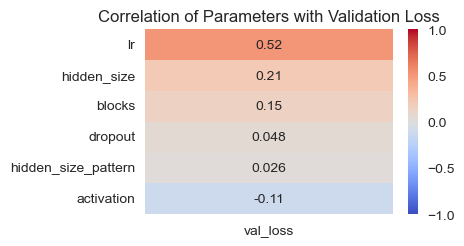

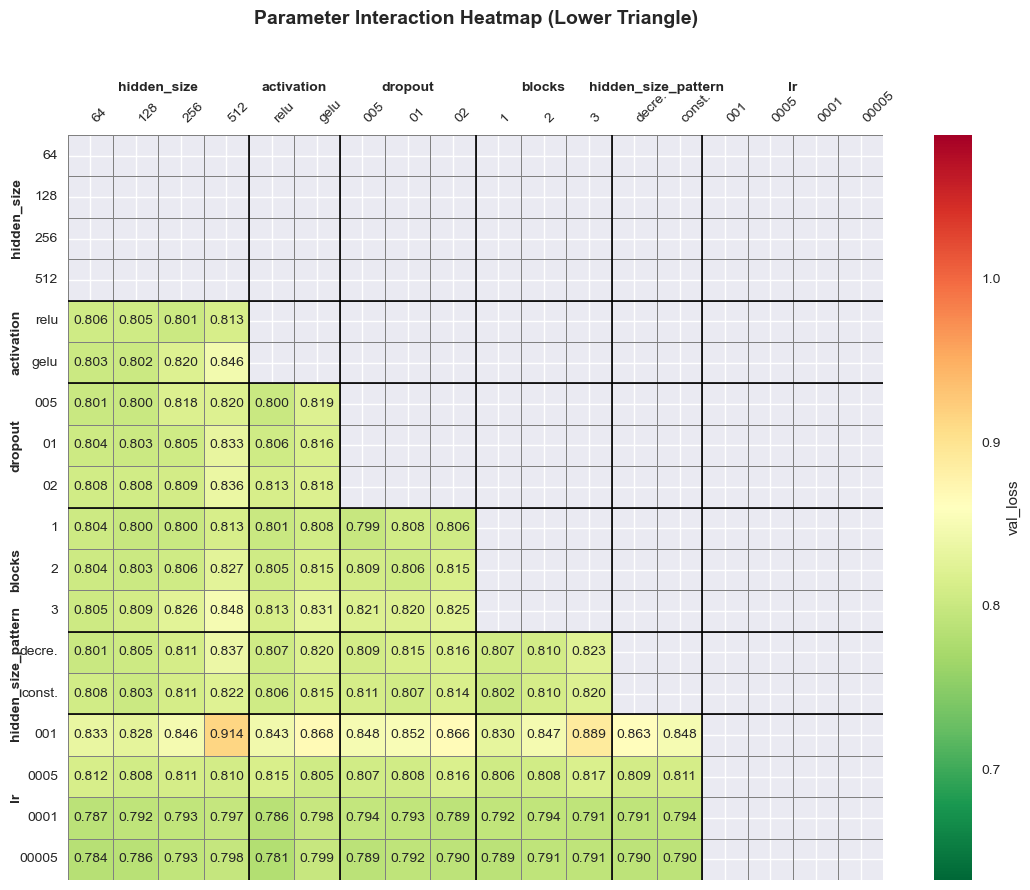

In [18]:
all_val_losses = pd.concat([tuning_history["val_loss"] for tuning_history in tuning_histories.values()])
val_loss_range = (all_val_losses.min(), all_val_losses.max())
print(val_loss_range)

for ft, tuning_history in tuning_histories.items():
    print(f"\n\n📈 Tuning results for {ft.upper()} features model:")
    print_tuning_top_results(tuning_history, topN=5, top_by=["val_loss", "mae"])

    plot_param_loss_corr(tuning_history, param_grid)
    plot_tuning_heatmap(tuning_history, param_grid, loss_range=val_loss_range)